# imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
checkpoint_loc = '/content/gdrive/MyDrive/11785/project/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST, CIFAR10, CIFAR100
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision import transforms
import numpy as np
import os
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import copy
import types

In [ ]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INIT_LR = 0.1
WEIGHT_DECAY_RATE = 0.0005
EPOCHS = 70
lr_decay_interval = 10
batch_size = 128

# Model

In [ ]:
'''class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, base_width=1, padding=1, batch_norm=None):
        super(BasicBlock, self).__init__()
        if batch_norm is None:
            bn_layer = nn.Batchnorm2D
        else:
            bn_layer = batch_norm

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=False)
        self.bn1 = bn_layer(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn2 = bn_layer(out_channels)

        self.downsample = downsample
        if self.downsample is None:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = self.downsample

        self.stride = stride

        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu2(out)
        return out


class ResNet34(nn.Module):

    def __init__(self, layers, num_classes=100, zero_init_residual=False, base_width=64, batch_norm=None):
        # def make_layer(self, block, planes, blocks, stride= 1, dilate = False):
        super(ResNet34, self).__init__()
        block = BasicBlock
        if batch_norm is None:
            bn_layer = nn.BatchNorm2d
        self.bn_layer = bn_layer

        self.conv_out_channels = 64
        self.in_channels = self.conv_out_channels
        self.base_width = base_width
        self.conv1 = nn.Conv2d(3, self.conv_out_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = bn_layer(self.conv_out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.container(block, 64, layers[0])
        self.layer2 = self.container(block, 128, layers[1], stride=2, dilate=False)
        self.layer3 = self.container(block, 256, layers[2], stride=2, dilate=False)
        self.layer4 = self.container(block, 512, layers[3], stride=2, dilate=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def container(self, block, in_channels, num_basicblocks, stride=1, dilate=False):
        bn_layer = self.bn_layer
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, in_channels, kernel_size=1, stride=stride, bias=False),
                bn_layer(in_channels),
            )

        layers = []
        layers.append(
            block(self.in_channels, in_channels, stride, downsample, self.base_width, padding=1, batch_norm=bn_layer))
        self.in_channels = in_channels
        for basic_blocks in range(1, num_basicblocks):
            layers.append(block(self.in_channels, in_channels, base_width=self.base_width, batch_norm=bn_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=False, num_workers=2)

    num_epochs = 30

    num_classes = 100

    net = ResNet34([3, 4, 6, 3], num_classes=100)
    network = net.to(device)
    learningRate = 0.1
    weightDecay = 5e-5
    criterion_label = nn.CrossEntropyLoss()
    optimizer_label = torch.optim.SGD(network.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9)
    network.train()
    network.to(device)
    print(network)'''

Files already downloaded and verified
Files already downloaded and verified
ResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
      (relu2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=False, num_workers=2)

    num_epochs = 30

    num_classes = 100

    net = ResNet50()
    network = net.to(device)
    learningRate = 0.1
    weightDecay = 5e-5
    criterion_label = nn.CrossEntropyLoss()
    optimizer_label = torch.optim.SGD(network.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9)
    network.train()
    network.to(device)
    print(network)


Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

# Dataset and loaders

In [ ]:
def get_cifar100_dataloaders(train_batch_size, test_batch_size):

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = CIFAR100('_dataset', True, train_transform, download=True)
    test_dataset = CIFAR100('_dataset', False, test_transform, download=False)

    train_loader = DataLoader(
        train_dataset,
        train_batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True)
    test_loader = DataLoader(
        test_dataset,
        test_batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True)

    return train_loader, test_loader

In [ ]:
def cifar100_experiment():
    
    BATCH_SIZE = 128
    LR_DECAY_INTERVAL = 20
    
    #net = VGG_SNIP('D').to(device)
    # net = 
    #optimiser = optim.SGD(
    #    net.parameters(),
    #    lr=INIT_LR,
    #    momentum=0.9,
    #    weight_decay=WEIGHT_DECAY_RATE)
    #lr_scheduler = optim.lr_scheduler.StepLR(
    #    optimiser, LR_DECAY_INTERVAL, gamma=0.1)
    #net = ResNet34([3, 4, 6, 3], num_classes=100)
    net = ResNet50()
    network = net.to(device)
    learningRate = 0.1
    weightDecay = 5e-5
    criterion_label = nn.CrossEntropyLoss()
    optimiser = torch.optim.SGD(network.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9)
    lr_scheduler = optim.lr_scheduler.StepLR(
        optimiser, LR_DECAY_INTERVAL, gamma=0.1)
    network.train()
    network.to(device)
    print(network)
    
    train_loader, val_loader = get_cifar100_dataloaders(BATCH_SIZE,
                                                       BATCH_SIZE)  # TODO

    return net, optimiser, lr_scheduler, train_loader, val_loader

In [ ]:
initial_net, optimiser, lr_scheduler, train_loader, val_loader = cifar100_experiment()
initial_net = initial_net.to(device)
torch.save(initial_net,'/content/init.pt')
initial_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

# Pruning

SNIP

In [ ]:
def pruning(model, density):

    grad_list, mask, weight_list = [], [], []
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            grad_list += list(abs(m.weight.grad.flatten().cpu().detach().numpy()))
            weight_list += list(abs(m.weight.flatten().cpu().detach().numpy()))

    threshold_grad = np.percentile(np.array((grad_list)), 100-density)
    threshold_weight = np.percentile(np.array((weight_list)), 100-density)

    weight_sparsity_check = np.where((weight_list)>=threshold_weight, 1, 0).sum()/len(weight_list)
    grad_sparsity_check = np.where((grad_list)>=threshold_grad, 1, 0).sum()/len(grad_list)

    # print(weight_sparsity_check, grad_sparsity_check)

    sums = 0
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            gradmask_numpy = np.where(abs(m.weight.grad.cpu().detach().numpy())>=threshold_grad, 1, 0)
            weightmask_numpy = np.where(abs(m.weight.cpu().detach().numpy())>=threshold_weight, 1, 0)
            weight_grad = np.logical_or(gradmask_numpy, weightmask_numpy).astype(float)
            sums += weight_grad.sum()
            # mask.append(torch.from_numpy(gradmask_numpy).cuda())
            mask.append(torch.from_numpy(weight_grad).cuda())
            # print(mask_numpy.shape)
        
    # print(len(mask))
    # print(sums/len(weight_list))
    del grad_list
    del weight_list
    del weightmask_numpy
    del gradmask_numpy
    del weight_grad
    
    return mask

def apply_prune_mask(model, keep_masks):

    prunable_layers = filter(
        lambda layer: isinstance(layer, nn.Conv2d) or isinstance(
            layer, nn.Linear), model.modules())

    for layer, keep_mask in zip(prunable_layers, keep_masks):
        assert (layer.weight.shape == keep_mask.shape)

        layer.weight.data[keep_mask == 0.] = 0.
        # print(100*np.count_nonzero(layer.weight.clone().cpu().detach().numpy())/(layer.weight.clone().flatten()).shape[0])



# Pruning while training

In [ ]:
def training(epoch, model, optimizer, scheduler, criterion, device, train_loader):
  model.train()
  avg_loss = 0.0
  av_loss=0.0
  total=0
  for batch_num, (feats, labels) in enumerate(train_loader):
      feats, labels = feats.to(device), labels.to(device)
      
      optimizer.zero_grad()

      outputs = model(feats)


      loss = criterion(outputs, labels.long())
      loss.backward()
      
      optimizer.step()
      
      avg_loss += loss.item()
      av_loss += loss.item() 
      total +=len(feats) 
      # if batch_num % 10 == 9:
      #     print('Epoch: {}\tBatch: {}\tAv-Loss: {:.4f}'.format(epoch+1, batch_num+1, av_loss/10))
      #     av_loss = 0.0

      torch.cuda.empty_cache()
      del feats
      del labels
      del loss

  del train_loader
  return avg_loss/total

In [ ]:
import time

def validate(epoch, model, criterion, device, data_loader):
    start_time = time.time()
    with torch.no_grad():
        model.eval()
        running_loss, accuracy,total  = 0.0, 0.0, 0

        
        for i, (X, Y) in enumerate(data_loader):
            
            X, Y = X.to(device), Y.to(device)
            output= model(X)
            loss = criterion(output, Y.long())

            _,pred_labels = torch.max(F.softmax(output, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            
            accuracy += torch.sum(torch.eq(pred_labels, Y)).item()

            running_loss += loss.item()
            total += len(X)

            torch.cuda.empty_cache()
            
            del X
            del Y
        
        return running_loss/total, accuracy/total, (time.time() - start_time)

In [ ]:
after_pruning_net, optimiser, lr_scheduler, train_loader, val_loader = cifar100_experiment()
after_pruning_net = after_pruning_net.to(device)
criterion = nn.CrossEntropyLoss()
density = 5

train_loss = training(1, after_pruning_net, optimiser, lr_scheduler, criterion, device,train_loader)
val_loss, val_acc,_ = validate(1, after_pruning_net, criterion, device, val_loader)
# Pre-training pruning using SKIP

keep_masks = pruning(after_pruning_net, density)  
apply_prune_mask(after_pruning_net, keep_masks)
max = 0
path = 'after_pruning.ptmodel'

for epoch in range(EPOCHS):
    if os.path.exists(path):
      checkpoint = torch.load(path)
      #after_pruning_net.load_state_dict(checkpoint['state_dict'])
    train_loss = training(epoch, after_pruning_net, optimiser, lr_scheduler, criterion, device,train_loader)

    val_loss, val_acc,_ = validate(epoch, after_pruning_net, criterion, device, val_loader)

    if max < val_acc*100:
      torch.save({'state_dict': after_pruning_net.state_dict()}, path)
    lr_scheduler.step()
    apply_prune_mask(after_pruning_net, keep_masks)

    print('Epoch: {} \t train-Loss: {:.4f}, \tval-Loss: {:.4f}, \tval-acc: {:.4f}'.format(epoch+1,  train_loss, val_loss, val_acc))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [ ]:
# torch.save(net,'/content/gdrive/MyDrive/11785/project/after_pruning.ptmodel')
#after_pruning_net = torch.load('/content/gdrive/MyDrive/11785/project/after_pruning.ptmodel')
# net = torch.load('after_pruning.ptmodel')

In [ ]:
 criterion = nn.CrossEntropyLoss()
 val_loss, val_acc,time_taken = validate(0, after_pruning_net, criterion, device, val_loader)
 print(val_loss, ' ', val_acc,' ',time_taken)

0.016427882385253906   0.4841   1.4642391204833984


# Quantization

Sparse matrix

In [ ]:
import copy
quantization_net = copy.deepcopy(after_pruning_net)
quantization_net.features


AttributeError: ignored

Feature wide quantization

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
bits = 5
for layer, (name, module) in enumerate(quantization_net.features._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    dev = module.weight.device
    weight = module.weight.data.cpu().numpy()
    org_shape =  module.weight.shape

    flatten_weights = weight.flatten()
    min_ = np.min(flatten_weights)
    max_ = np.max(flatten_weights)
    space = np.linspace(min_, max_, num=2**bits)

    print(module.weight.flatten().size())
    kmeans = KMeans(n_clusters=len(space), init=space.reshape(-1,1), n_init=1, precompute_distances=True, algorithm="full")
    kmeans.fit(weight.reshape(-1,1))
    new_weight = kmeans.cluster_centers_[kmeans.labels_].reshape(-1)
    mat = new_weight.reshape(org_shape)
    module.weight.data = torch.from_numpy(mat).to(dev)

  else:
    print('skipped')

----------  name: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1728])
----------  name: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([64])
----------  name: ReLU(inplace=True)
skipped
----------  name: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([36864])
----------  name: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([64])
----------  name: ReLU(inplace=True)
skipped
----------  name: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
skipped
----------  name: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([73728])
----------  name: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([128])
----------  name: ReLU(inplace=True)
skipped
----------  name: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([147456])

Classifier quantization

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
bits = 5
for layer, (name, module) in enumerate(quantization_net.classifier._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    dev = module.weight.device
    weight = module.weight.data.cpu().numpy()
    org_shape =  module.weight.shape

    flatten_weights = weight.flatten()
    min_ = np.min(flatten_weights)
    max_ = np.max(flatten_weights)
    space = np.linspace(min_, max_, num=2**bits)

    print(module.weight.flatten().size())
    kmeans = KMeans(n_clusters=len(space), init=space.reshape(-1,1), n_init=1, precompute_distances=True, algorithm="full")
    kmeans.fit(weight.reshape(-1,1))
    new_weight = kmeans.cluster_centers_[kmeans.labels_].reshape(-1)
    mat = new_weight.reshape(org_shape)
    module.weight.data = torch.from_numpy(mat).to(dev)

  else:
    print('skipped')

In [ ]:
quantization_net = torch.load('/content/gdrive/MyDrive/11785/project/after_quantization.ptmodel')

In [ ]:
 quantization_net.cuda()
 val_loss, val_acc,time_taken = validate(0, quantization_net, criterion, device, val_loader)
 print(val_acc,' ',time_taken)

In [ ]:
torch.save(quantization_net,'after_quantization.ptmodel')
torch.save(quantization_net,'/content/gdrive/MyDrive/11785/project/after_quantization.ptmodel')

# Post quantization comparison

In [ ]:
layer_names = []
post_quant_weights_unique = []
for layer, (name, module) in enumerate(quantization_net.features._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    weight = module.weight.data.cpu().numpy()
    flatten_weights = weight.flatten()
    layer_names.append(module.__class__.__name__)
    post_quant_weights_unique.append(np.unique(flatten_weights))
  else:
    print('skipped')
for layer, (name, module) in enumerate(quantization_net.classifier._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    weight = module.weight.data.cpu().numpy()
    flatten_weights = weight.flatten()
    layer_names.append(module.__class__.__name__)
    post_quant_weights_unique.append(np.unique(flatten_weights))
  else:
    print('skipped')

In [ ]:
layer_names = []
pre_quant_weights_unique = []
for layer, (name, module) in enumerate(after_pruning_net.features._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    weight = module.weight.data.cpu().numpy()
    flatten_weights = weight.flatten()
    layer_names.append(module.__class__.__name__)
    pre_quant_weights_unique.append(np.unique(flatten_weights))
  else:
    print('skipped')
for layer, (name, module) in enumerate(after_pruning_net.classifier._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    weight = module.weight.data.cpu().numpy()
    flatten_weights = weight.flatten()
    layer_names.append(module.__class__.__name__)
    pre_quant_weights_unique.append(np.unique(flatten_weights))
  else:
    print('skipped')

In [ ]:
if len(post_quant_weights_unique) == len(pre_quant_weights_unique):
  print('true')

In [ ]:
i = 0
for old_w,new_w in zip(pre_quant_weights_unique,post_quant_weights_unique):
  print('layer_names [',layer_names[i],'] -> unique weights count old:',len(old_w),', new:',len(new_w))
  i+=1

In [ ]:
import copy
post_process_net = torch.load('/content/gdrive/MyDrive/11785/project/after_quantization.ptmodel')

In [ ]:
 val_loss, val_acc,time_taken = validate(0, post_process_net, criterion, device, val_loader)
 print(val_acc,time_taken)

In [ ]:
import torch.quantization
post_process_net = post_process_net.to('cpu')
device='cpu'
post_process_net.qconfig = torch.quantization.default_qconfig
torch.quantization.prepare(post_process_net, inplace=True)
torch.quantization.convert(post_process_net, inplace=True)

In [ ]:
 post_process_net.cpu()
 val_loss, val_acc,time_taken = validate(0, post_process_net, criterion, device, val_loader)
 print(val_acc,time_taken)

In [ ]:
torch.save(net,'after_quantization_int.ptmodel')
torch.save(net,'/content/gdrive/MyDrive/11785/project/after_quantization_int.ptmodel')

In [ ]:
layer_names = []
post_quant_weights_int_unique = []
for layer, (name, module) in enumerate(net.features._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    weight = module.weight.data.cpu().numpy()
    flatten_weights = weight.flatten()
    post_quant_weights_int_unique.append(np.unique(flatten_weights))
  else:
    print('skipped')

# Visualization convolution weights

In [ ]:
import matplotlib.pyplot as plt
def plot_filters_multi_channel(t,img_name):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig(img_name, dpi=100)    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_weights(model, layer_num,img_name):
  
  layer = model.features[layer_num]
  
  if isinstance(layer, nn.Conv2d):
    weight_tensor = model.features[layer_num].weight.data
    if weight_tensor.shape[1] == 3:
      plot_filters_multi_channel(weight_tensor,img_name)
    else:
        print("Can only plot weights with three channels with single channel = False")     
  else:
    print("Can only visualize layers which are convolutional")

In [ ]:
import matplotlib.pyplot as plt
initial_net = initial_net.to('cpu')
after_pruning_net = after_pruning_net.to('cpu')
quantization_net = quantization_net.to('cpu')
plot_weights(initial_net, 0,'initial state of weights')
plot_weights(after_pruning_net, 0,'after pruning')
plot_weights(quantization_net, 0,'after quantization with k-means')

# Visualization Activation layer

Linear(in_features=512, out_features=512, bias=True)
[-2.62651205e-01 -2.00239673e-01 -1.52694285e-01 -1.30984098e-01
 -1.11580133e-01 -9.03302729e-02 -6.05782866e-02 -4.06768061e-02
 -2.74116416e-02 -1.84960216e-02 -1.17350705e-02 -5.85467555e-03
 -2.37078825e-03 -6.54769887e-04  2.78642801e-06  2.29578675e-03
  6.95845997e-03  1.36291971e-02  2.15460546e-02  3.15798894e-02
  4.34518382e-02  5.56850210e-02  6.92472532e-02  7.85576776e-02
  9.07434896e-02  1.12685129e-01  1.39182061e-01  1.52690858e-01
  1.75977081e-01  1.93883166e-01  2.74437904e-01  4.24591839e-01]


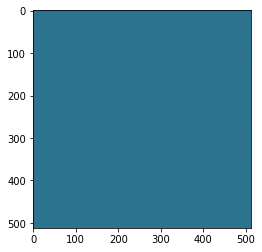

In [ ]:
print(quantization_net.classifier[0])
quantization_net = quantization_net.to('cpu')
print(np.unique(quantization_net.classifier[0].weight.data.flatten()))
plt.imshow(quantization_net.classifier[0].weight.data)